In [1]:
# Some useful imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
class BlackScholes:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def generate(self, x, T, N, n):
        S = np.zeros((n, N))
        S[:, 0] = x
        dt = T / N
        for i in range(1, N):
            S[:, i] = S[:, i-1] + S[:, i-1] * (self.mu * dt + self.sigma * np.sqrt(dt) * np.random.randn(n))
        return S

<Figure size 1200x800 with 0 Axes>

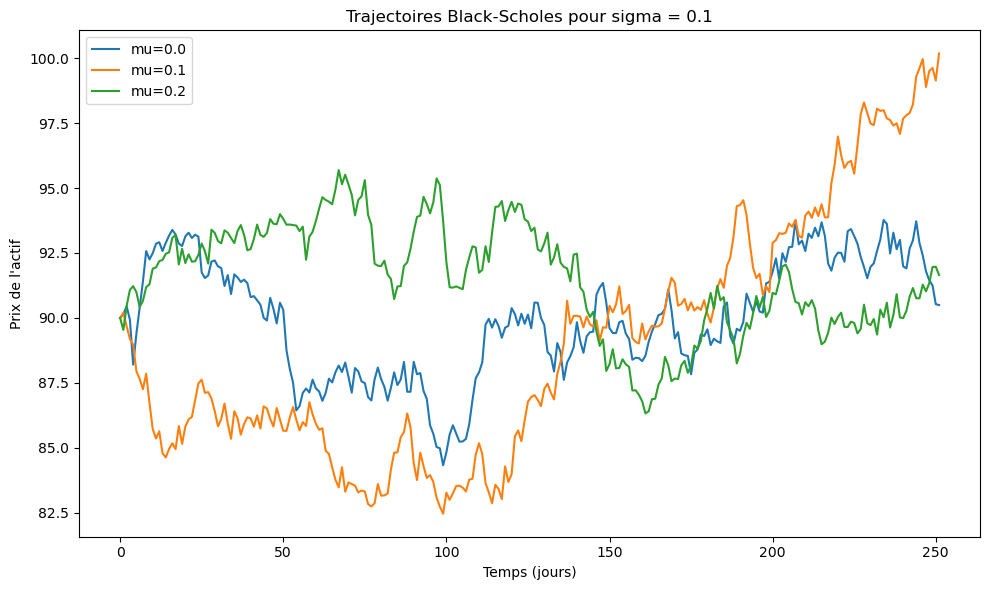

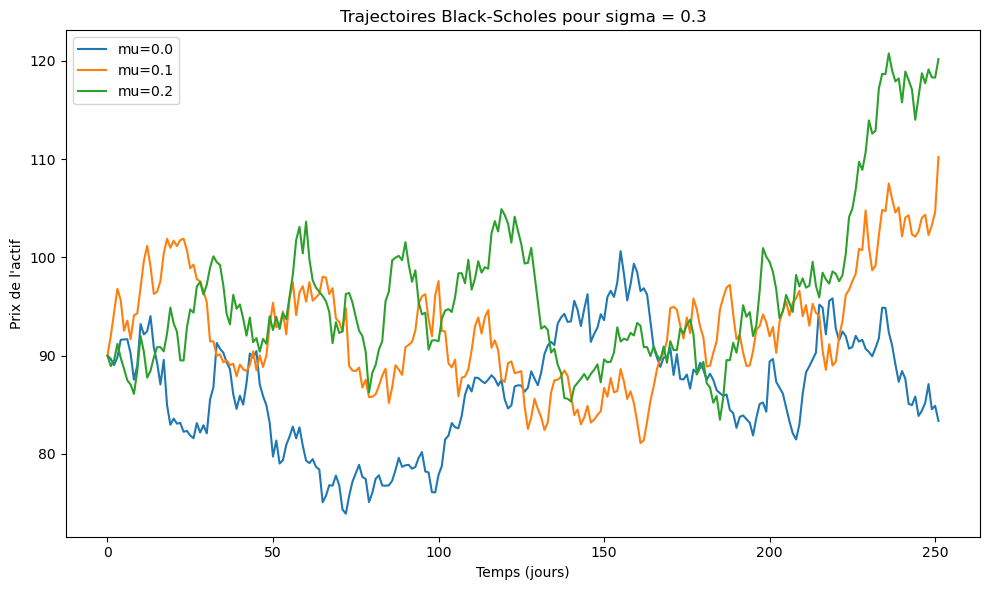

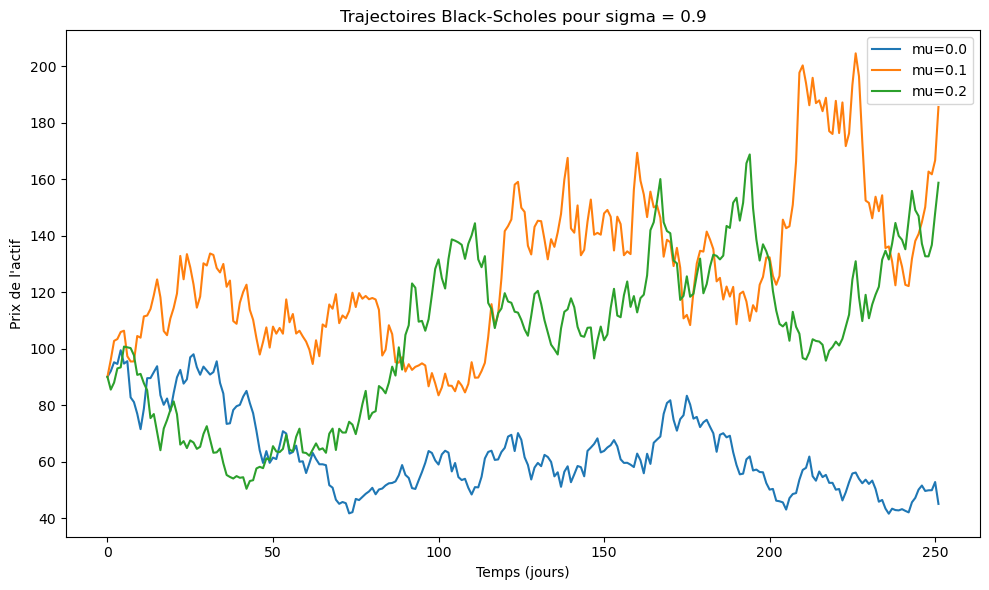

In [3]:
# Parameters
r = 0.05
x = 90

n = 1
N = 252
T = 1

# Listes de mu et sigma à tester
mu_list = [0.0, 0.1, 0.2]
sigma_list = [0.1, 0.3, 0.9]

plt.figure(figsize=(12, 8))

# Génération des graphiques
for sigma in sigma_list:
    plt.figure(figsize=(10, 6))
    for mu in mu_list:
        model = BlackScholes(mu, sigma)
        trajectory = model.generate(x, T, N, n)[0]
        plt.plot(trajectory, label=f"mu={mu}")
    
    plt.title(f"Trajectoires Black-Scholes pour sigma = {sigma}")
    plt.xlabel("Temps (jours)")
    plt.ylabel("Prix de l'actif")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Prix du call européen
$$C(t, x) = xN(d_1(T-t, x))-Ke^{-r(T-t)} N(d_2 (T-t, x))$$
$$d_1(t,x) = \frac{1}{\sigma \sqrt{T-t}} \left( \log(x/K) + (r+\sigma^2/2)(T-t) \right), \ \ \ d_2(t,x)=d_1(t,x)-\sigma \sqrt{T-t}$$

In [4]:
def d1(theta, x, T, K, r, sigma):
    d = np.log(x/K) + (r+sigma**2/2)*theta
    d = d / (sigma*np.sqrt(theta))
    return d

def d2(theta, x, T, K, r, sigma):
    return d1(theta, x, T, K, r, sigma) - sigma * np.sqrt(theta)

def C(S, T, N, K, r, sigma):
    p = np.zeros(N)
    for i in range(N-1):
        t = i * T / N
        p[i] = S[i] * norm.cdf(d1(T-t, S[i], T, K, r, sigma)) - K * np.exp(-r*(T-t)) * norm.cdf(d2(T-t, S[i], T, K, r, sigma))
    p[N-1] = max(0, S[N-1]-K)
    return p

In [75]:
mu = 0.1
sigma = 0.1
n = 1
N = 50
T = 1

In [76]:
model = BlackScholes(mu, sigma)
trajectory = model.generate(x, T, N, n)[0]

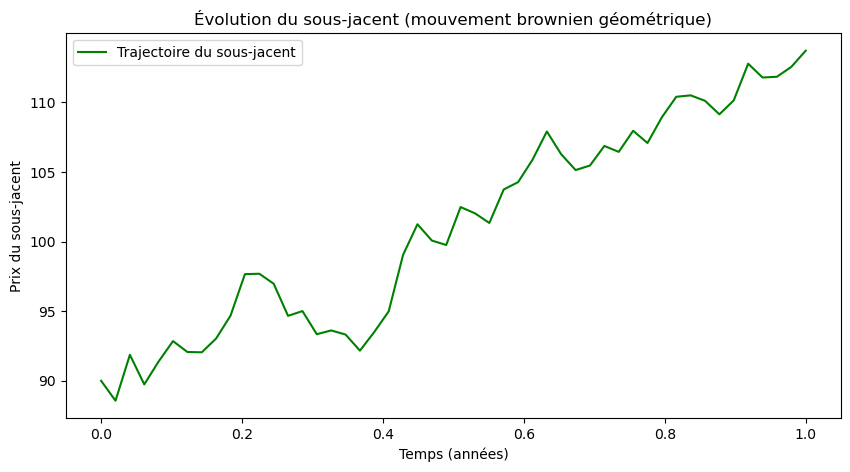

In [77]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, trajectory, label='Trajectoire du sous-jacent', color='green')
plt.xlabel("Temps (années)")
plt.ylabel("Prix du sous-jacent")
plt.title("Évolution du sous-jacent (mouvement brownien géométrique)")
plt.legend()
plt.show()

In [78]:
K = 90
prices = C(trajectory, T, N, K, r, sigma)

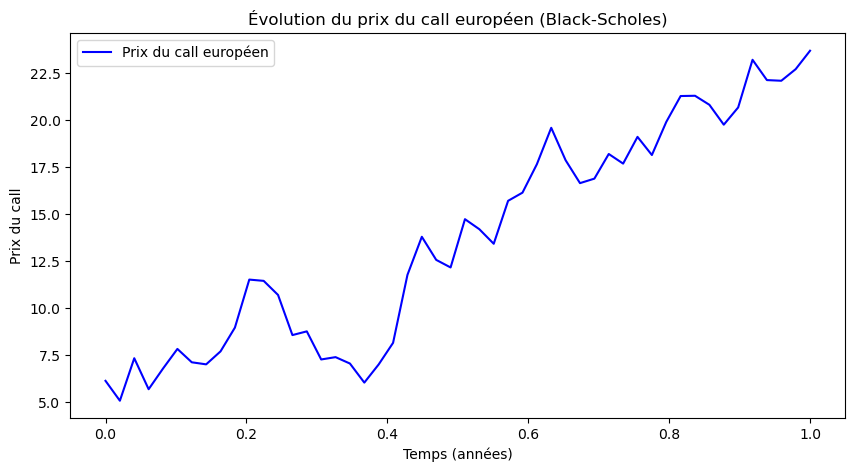

In [79]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, prices, label='Prix du call européen', color='blue')
plt.xlabel("Temps (années)")
plt.ylabel("Prix du call")
plt.title("Évolution du prix du call européen (Black-Scholes)")
plt.legend()
plt.show()

# Couverture

In [80]:
def hedging(S, C0, T, N, K, r, sigma):
    dt = T / N
    H0 = np.zeros(N)
    H = np.zeros(N)
    V = np.zeros(N)
    
    # Initialisation
    tau = T
    H[0] = norm.cdf(d1(tau, S[0], T, K, r, sigma))
    H0[0] = C0 - H[0] * S[0]
    V[0] = H[0] * S[0] + H0[0]

    for i in range(1, N):
        t = i * dt
        tau = T - t

        # 1. Le cash évolue au taux sans risque
        H0[i] = H0[i-1] * np.exp(r * dt)

        # 2. Nouveau delta
        H[i] = norm.cdf(d1(tau, S[i], T, K, r, sigma))

        # 3. Ajustement du cash en fonction du changement de delta
        H0[i] -= (H[i] - H[i-1]) * S[i]

        # 4. Valeur du portefeuille (après ajustement)
        V[i] = H[i] * S[i] + H0[i]

    return H0, H, V

In [81]:
(H0, H, val) = hedging(trajectory, prices[0], T, N, K, r, sigma)

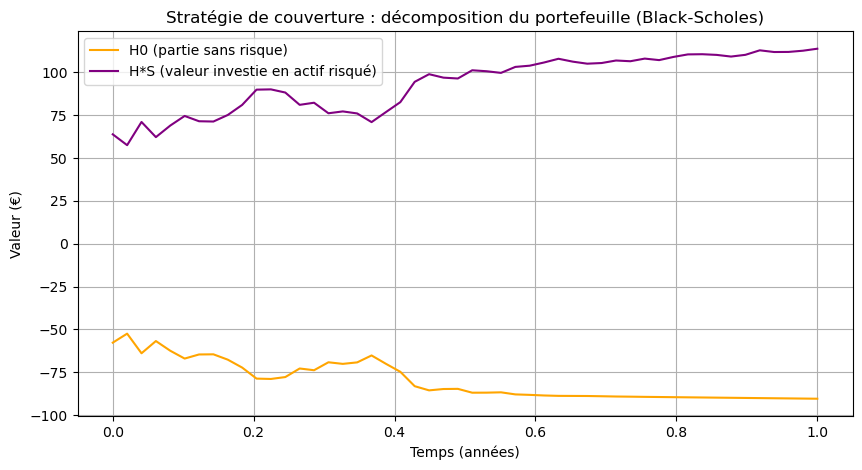

In [82]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, H0, label='H0 (partie sans risque)', color='orange')
plt.plot(time_grid, H * trajectory, label='H*S (valeur investie en actif risqué)', color='purple')
plt.xlabel("Temps (années)")
plt.ylabel("Valeur (€)")
plt.title("Stratégie de couverture : décomposition du portefeuille (Black-Scholes)")
plt.legend()
plt.grid(True)
plt.show()


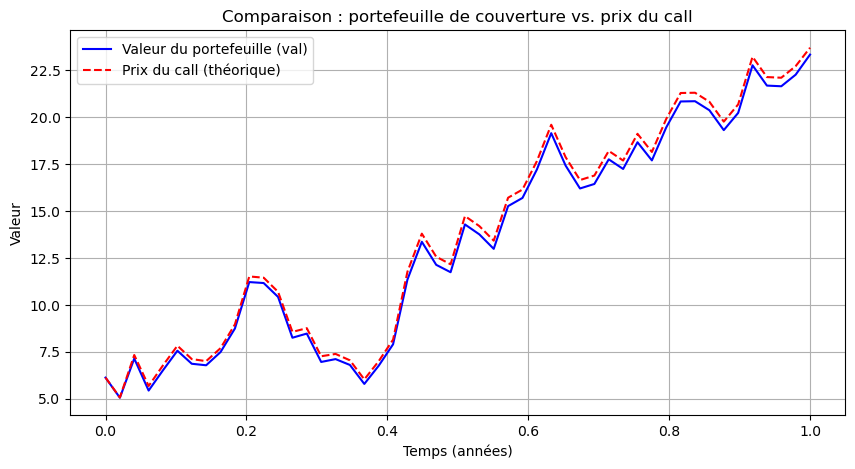

In [83]:
# Tracé de val et prices sur le même graphique
plt.figure(figsize=(10, 5))
plt.plot(time_grid, val, label='Valeur du portefeuille (val)', color='blue')
plt.plot(time_grid, prices, label='Prix du call (théorique)', color='red', linestyle='--')
plt.xlabel("Temps (années)")
plt.ylabel("Valeur")
plt.title("Comparaison : portefeuille de couverture vs. prix du call")
plt.legend()
plt.grid(True)
plt.show()